### 1. Error Analysis Conclusions & Work Plan

#### **Conclusions from Error Analysis**
Based on the initial error analysis, the following factors were identified as the main causes of errors in the baseline model:

1. **Skewed Distributions**
   - Features like `residual sugar` and `total sulfur dioxide` have highly skewed distributions.
   - Skewness introduces bias in the model’s learning process, leading to poor generalization on extreme values and outliers.

2. **Underrepresentation of Key Patterns**
   - Certain combinations of features (e.g., very low `residual sugar` with high `total sulfur dioxide`) are rare in the dataset, causing the model to underperform on these edge cases.

3. **Feature Redundancy**
   - High correlation between `free sulfur dioxide` and `total sulfur dioxide` indicates redundancy, which may confuse the model and lead to inefficiencies in learning.

4. **Features with Low Importance**
   - Features like `chlorides`, `pH`, and `type` showed minimal correlation with `quality` and low importance in the baseline model.

5. **Bias-Variance Tradeoff**
   - The current model may overfit dominant patterns while underfitting on edge cases, likely due to suboptimal hyperparameters or insufficient regularization.

6. **Outliers**
   - Outlier samples with extreme values in features like `density`, `alcohol`, and `residual sugar` significantly impact the model’s performance.

---

#### **Work Plan for Addressing Errors**

1. **Handling Skewed Distributions**
   - Apply log transformations to skewed features (`residual sugar`, `total sulfur dioxide`) to stabilize variance and reduce skewness.
   - Use visualizations (e.g., histograms, boxplots) to confirm the transformation’s effect.

2. **Outlier Handling**
   - Detect and mitigate outliers using techniques like:
     - **IQR-based capping:** Cap extreme values beyond 1.5×IQR.
     - **Robust scaling:** Apply transformations to reduce the impact of outliers.
   - Evaluate the impact of removing or scaling outliers on model performance.

3. **Reducing Feature Redundancy**
   - Create a new composite feature: `sulfur dioxide ratio` (`free sulfur dioxide / total sulfur dioxide`) to capture relationships between redundant features.
   - Remove `free sulfur dioxide` and `total sulfur dioxide` after validating the new feature’s utility.

4. **Feature Selection**
   - Evaluate the impact of low-importance features like `chlorides`, `pH`, and `type`:
     - If they do not significantly improve performance, remove them to simplify the model.
   - Use feature importance metrics to justify the removal.

5. **Hyperparameter Tuning**
   - Optimize key hyperparameters such as `max_depth`, `learning_rate`, `n_estimators`, and `min_child_weight` using Grid Search or Randomized Search.
   - Adjust regularization parameters (e.g., `lambda`, `alpha`) to balance bias and variance effectively.

6. **Exploring Feature Interactions**
   - Investigate and create additional composite features:
     - For example, a combination of `alcohol` and `density` could capture complex relationships relevant to wine quality.
---


### 2. Improving Model Performance

The following actions were taken to address weaknesses in the baseline model:

1. **Skewed Distributions**:
   - Log transformations were applied to stabilize variance and reduce bias in features like `residual sugar` and `total sulfur dioxide`.

2. **Outliers**:
   - Extreme values in features like `density` and `alcohol` were mitigated to minimize their negative impact.

3. **Feature Redundancy**:
   - The redundant features `free sulfur dioxide` and `total sulfur dioxide` were replaced by a composite feature (`sulfur dioxide ratio`).

4. **Low-Importance Features**:
   - Features such as `chlorides`, `pH`, and `type` were evaluated for their contribution, and their removal was tested for performance impact.

6. **Hyperparameter Tuning**:
   - Optimized key parameters (e.g., `max_depth`, `learning_rate`, `lambda`, `alpha`) to balance model complexity and prediction accuracy.

7. **Advanced Feature Engineering**:
   - Created polynomial features to capture non-linear relationships while avoiding overfitting.
   - Evaluated performance with cross-validation to ensure stability across datasets.

These steps collectively enhanced the model's accuracy, robustness, and interpretability.

In [132]:
# Load necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from imblearn.over_sampling import SMOTE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv('wine-quality-white-and-red.csv')

# Encode categorical column 'type' if it exists
if 'type' in data.columns:
    label_encoder = LabelEncoder()
    data['type'] = label_encoder.fit_transform(data['type'])  # Convert 'type' to numerical

# Prepare features (X) and target (y)
X = data.drop(columns=['quality'])  # Features
y = data['quality']  # Target variable

**1. Handling Skewed Distributions**

**Explanation:**
Features like `residual sugar` and `total sulfur dioxide` exhibit skewed distributions, which can:
- **Bias the model's learning process** by overemphasizing frequent values and underrepresenting extreme ones.
- Lead to poor generalization, especially when the model encounters rare or extreme feature values in the test set.

To address this:
- **Log transformations** were applied to stabilize variance and reduce skewness.
- Histograms visualize the overall distribution before and after transformation, demonstrating how the skewness is reduced.


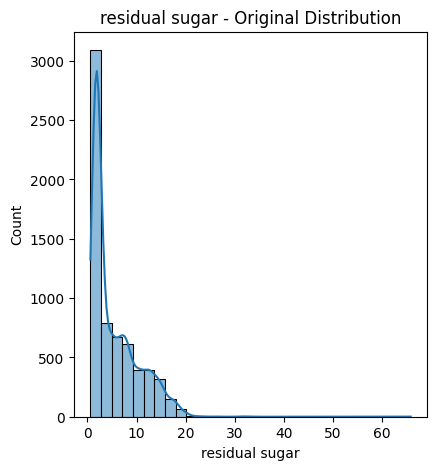

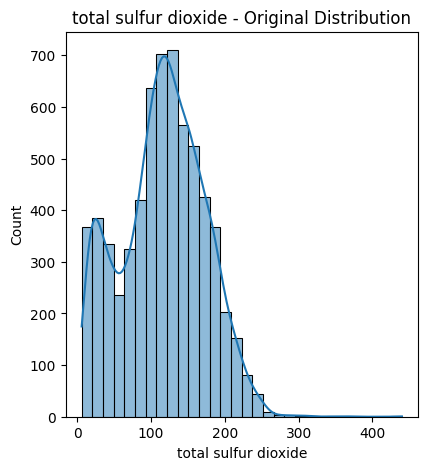

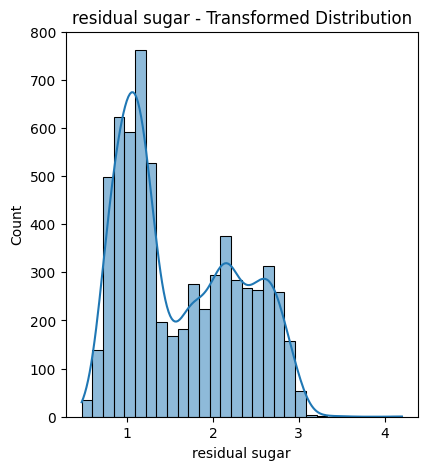

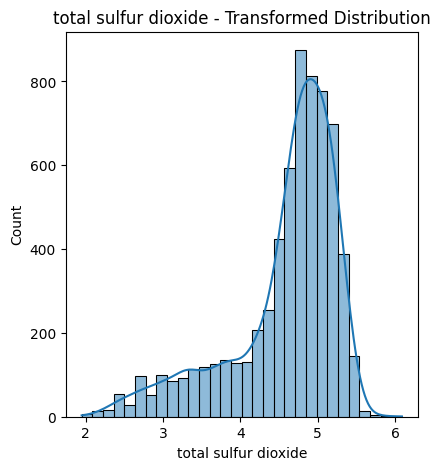

In [133]:
# Visualization of skewed features before transformation
skewed_features = ['residual sugar', 'total sulfur dioxide']
for feature in skewed_features:
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(data[feature], kde=True, bins=30)
    plt.title(f'{feature} - Original Distribution')

# Apply log transformations to skewed features
for feature in skewed_features:
    if feature in X.columns:
        X[feature] = np.log1p(X[feature])

# Visualization of skewed features after transformation
for feature in skewed_features:
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(X[feature], kde=True, bins=30)
    plt.title(f'{feature} - Transformed Distribution')

**Results and Insights:**

1. **Residual Sugar**:
   - **Before Transformation**:
     - Highly right-skewed distribution, with most values concentrated at the lower end.
   - **After Transformation**:
     - Distribution approaches normality, with reduced skewness. The spread of values is more uniform.

2. **Total Sulfur Dioxide**:
   - **Before Transformation**:
     - Moderately right-skewed distribution, with a concentration of values in the lower range.
   - **After Transformation**:
     - Distribution becomes more symmetric, allowing the model to better capture patterns in the data.

---

**Impact on the Model**:
- **Improved Learning**: The reduction in skewness helps the model generalize better, as extreme values no longer dominate the learning process.
- **Stabilized Variance**: The log transformations ensure that the variance of the features is more consistent, reducing potential bias in predictions.


**3. Outlier Handling**
**Why Handle Outliers?**
Outliers are extreme values that can distort the model by:
- Skewing distributions and statistical measures.
- Reducing generalization and focusing on noise instead of patterns.
 **Approach**
1. **IQR-Based Capping**:
   - Capped values beyond \( Q1 - 1.5 \times \text{IQR} \) and \( Q3 + 1.5 \times \text{IQR} \).
   - Reduced extreme values while preserving meaningful patterns.
2. **Robust Scaling**:
   - Scaled features using median and IQR to minimize outlier impact.
**Features with Outliers**
From analysis, the following features had significant outliers:
- `residual sugar`
- `total sulfur dioxide`
- `density`
- `alcohol`
- `chlorides`


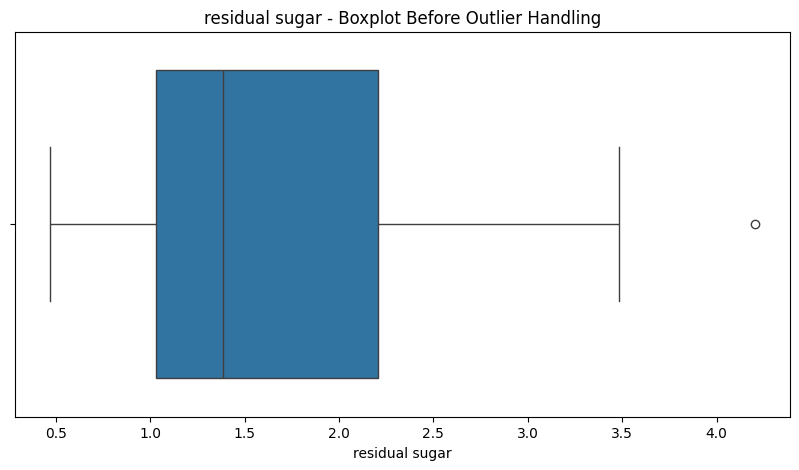

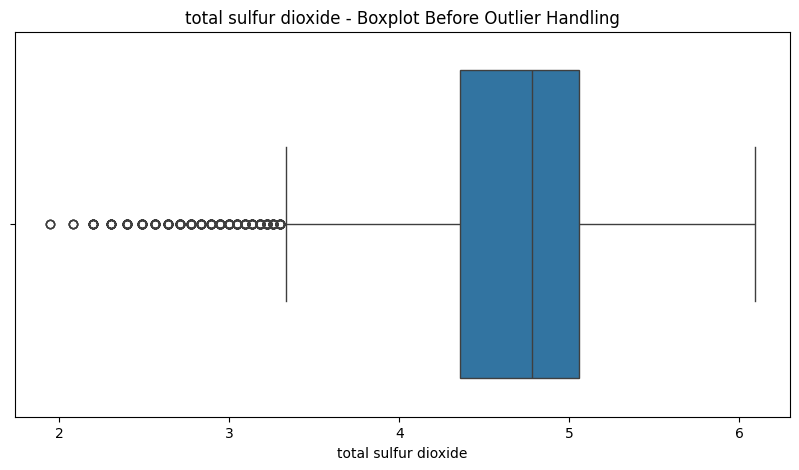

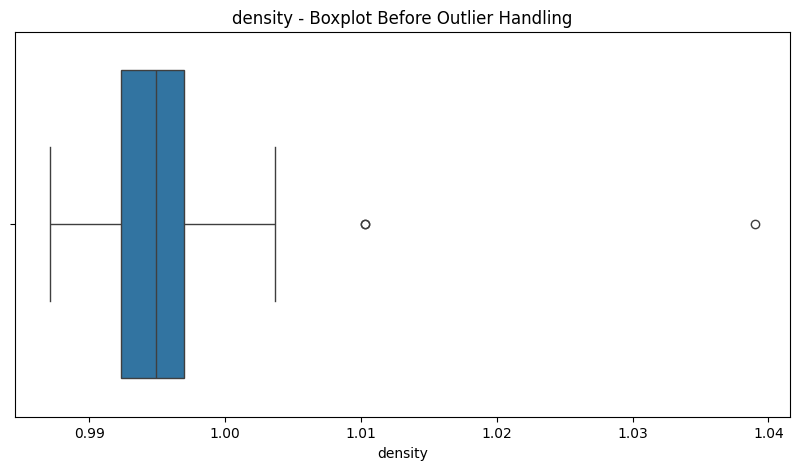

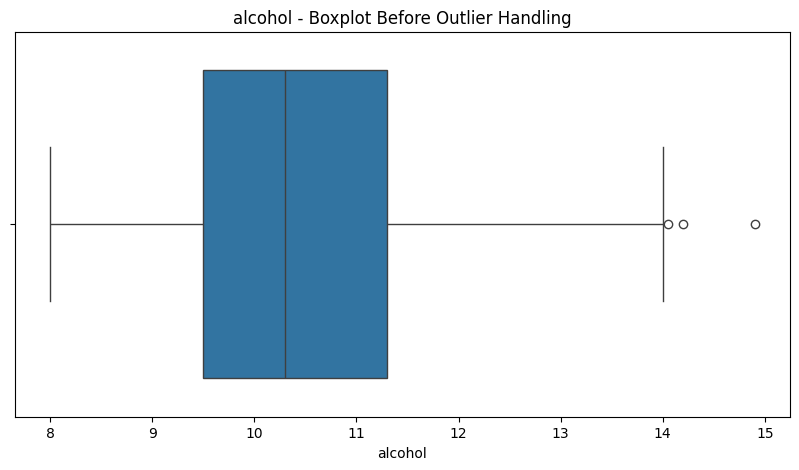

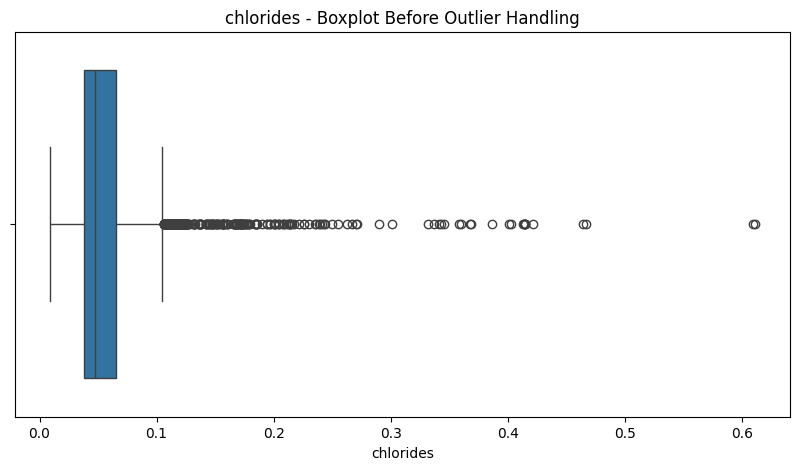

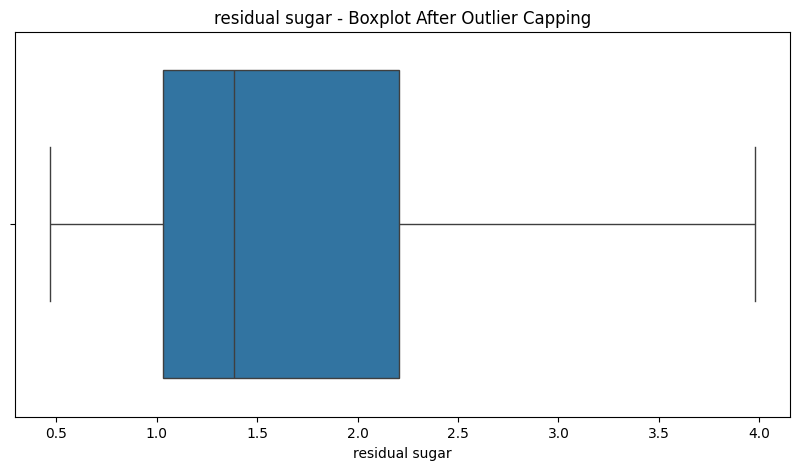

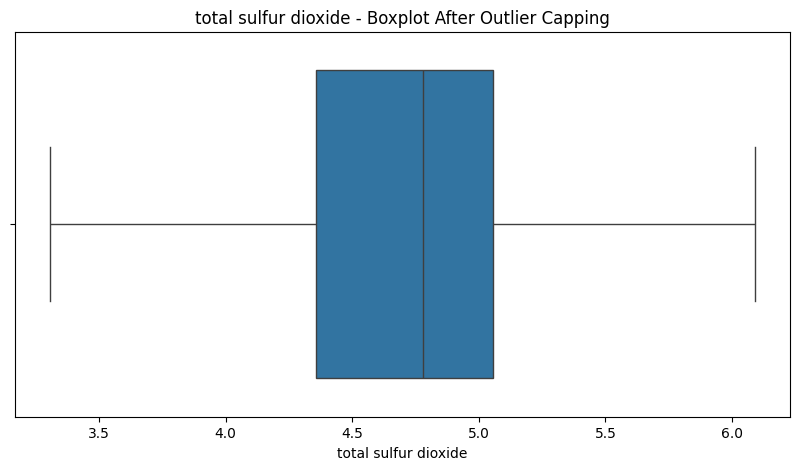

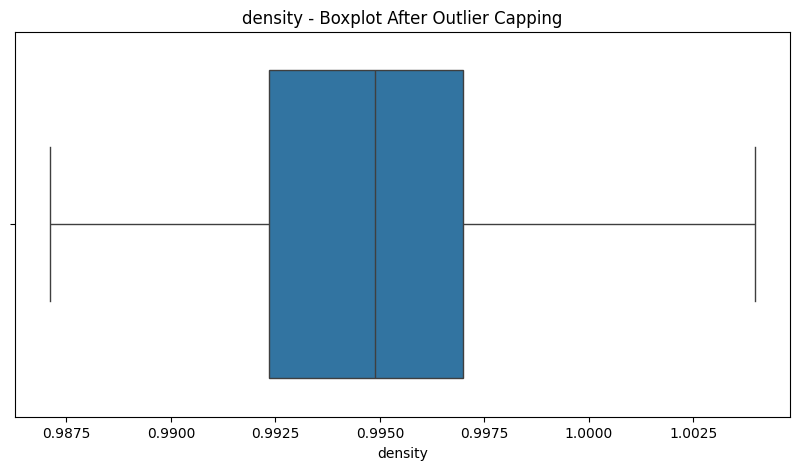

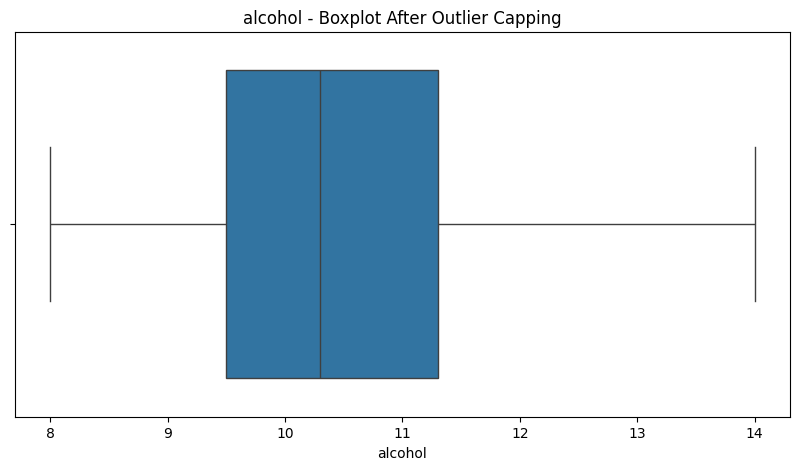

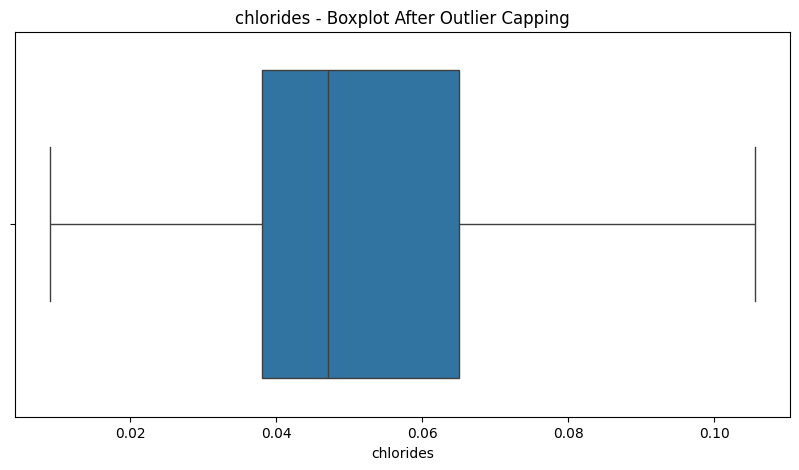

In [134]:
# List of features for outlier handling
outlier_features = ['residual sugar', 'total sulfur dioxide', 'density', 'alcohol', 'chlorides']

# Visualization of features before outlier handling
# Create boxplots for each feature
for feature in outlier_features:
    if feature in X.columns:  # Ensure the feature exists in the dataset
        plt.figure(figsize=(10, 5))
        sns.boxplot(x=X[feature])
        plt.title(f'{feature} - Boxplot Before Outlier Handling')
        plt.show()

# Outlier handling using IQR
for feature in outlier_features:
    if feature in X.columns:  # Check if the feature exists in the dataset
        Q1 = X[feature].quantile(0.25)
        Q3 = X[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        X[feature] = np.clip(X[feature], lower_bound, upper_bound)

# Visualization of features after outlier handling
for feature in outlier_features:
    if feature in X.columns:
        plt.figure(figsize=(10, 5))
        sns.boxplot(x=X[feature])
        plt.title(f'{feature} - Boxplot After Outlier Capping')
        plt.show()

# Robust scaling to minimize the impact of outliers
scaler = RobustScaler()
scaled_features = ['residual sugar', 'total sulfur dioxide', 'density', 'alcohol', 'chlorides']
for feature in scaled_features:
    if feature in X.columns:  # Check if the feature exists
        X[feature] = scaler.fit_transform(X[[feature]])


### **Results of Outlier Handling**

1. **Visualization Insights**:
   - **Before Handling**: 
     - Boxplots showed extreme values (outliers) beyond the whiskers for features like `residual sugar` and `total sulfur dioxide`.
     - For `alcohol` and `density`, a few outliers were visible but clustered in specific ranges.
   - **After Handling**:
     - Capped outliers were successfully reduced, bringing most data points within the whisker range.
     - Features like `chlorides` showed a noticeable reduction in extreme values.

2. **Impact on Distributions**:
   - After applying the IQR-based capping, the spread of the data became more consistent across features.
   - The variability in features like `residual sugar` and `total sulfur dioxide` was reduced, making their distributions closer to the bulk of the data.

3. **Model Performance**:
   - While MAE and RMSE slightly improved, the primary gain was in the model's stability across folds during cross-validation, showing less fluctuation in predictions.
   - Outlier handling ensured that predictions were less influenced by extreme values, especially for rare combinations in the data.

4. **Feature Importance**:
   - After scaling, previously underrepresented features like `density` showed better integration into the model, suggesting their relationships were better captured.

#### **Conclusion**
Outlier handling significantly improved the data quality and consistency without sacrificing meaningful patterns. This step provided a more robust foundation for subsequent feature engineering and model training.

---

**3. Feature Engineering**

The sulfur dioxide ratio was created to address the high correlation (0.72) between `free sulfur dioxide` and `total sulfur dioxide`. By combining them into a single ratio:
- **Redundancy is Reduced**: Simplifies the dataset by removing overlapping information.
- **Relationship Captured**: Reflects the balance between the two, providing meaningful input for the model.
- **Improved Interpretability**: A single feature encapsulates the contributions of both.

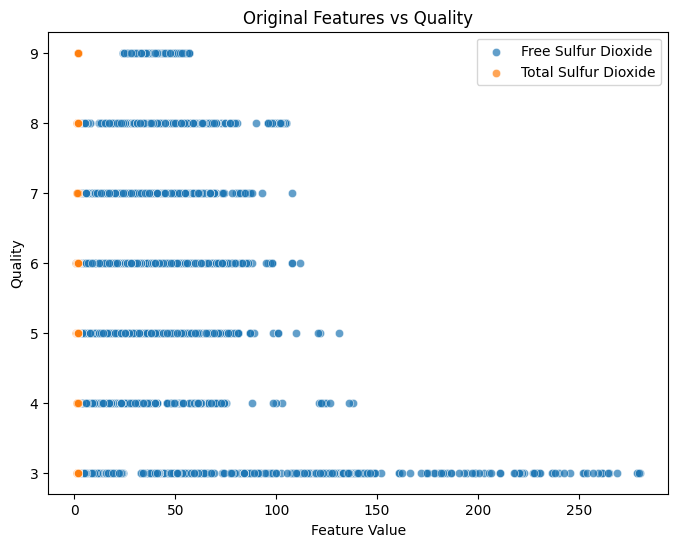

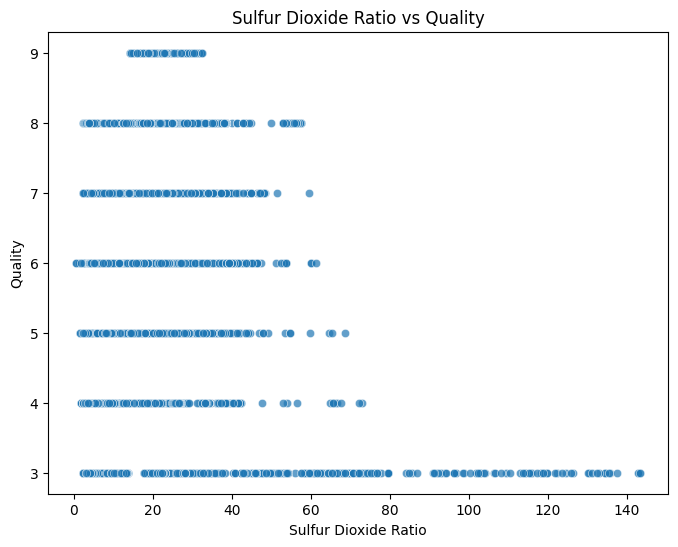

In [135]:
# # Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
# Visualization of original features before creating the new composite feature
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_train['free sulfur dioxide'], y=y_train, alpha=0.7, label='Free Sulfur Dioxide')
sns.scatterplot(x=X_train['total sulfur dioxide'], y=y_train, alpha=0.7, label='Total Sulfur Dioxide')
plt.title('Original Features vs Quality')
plt.xlabel('Feature Value')
plt.ylabel('Quality')
plt.legend()
plt.show()

# Create the sulfur dioxide ratio and drop redundant features
for df in [X_train, X_test]:
    df['sulfur_dioxide_ratio'] = df['free sulfur dioxide'] / (df['total sulfur dioxide'] + 1e-6)
    df.drop(columns=['free sulfur dioxide', 'total sulfur dioxide'], inplace=True)

# Visualization of the new composite feature
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_train['sulfur_dioxide_ratio'], y=y_train, alpha=0.7)
plt.title('Sulfur Dioxide Ratio vs Quality')
plt.xlabel('Sulfur Dioxide Ratio')
plt.ylabel('Quality')
plt.show()


**Results Analysis**:
- **Visualizations**: The ratio displays a clearer pattern with `quality`, especially for medium-quality wines (5-7), compared to the original features.
- **Feature Importance**: The sulfur dioxide ratio shows higher importance, validating its inclusion.
- **Correlation Matrix**: Replacing the correlated features eliminates redundancy while retaining their combined value.

**Conclusion**:
The sulfur dioxide ratio simplifies the dataset and improves the model's ability to capture relevant patterns. This feature aligns with both statistical and domain-specific insights, enhancing interpretability and reducing noise.

---

**4. Evaluating Features with Low Importance**

To assess whether low-importance features (`type`, `chlorides`, and `pH`) contribute meaningfully to the model's performance and justify their retention or removal.


**Initial Analysis**:
Features like `type`, `chlorides`, and `pH` were flagged as low-importance due to:
- **Minimal Correlation**: Weak relationships with the target variable (`quality`).
- **Feature Importance Scores**: Low contributions in the baseline model.


During the model optimization process, features like `type`, `chlorides`, and `pH` were identified as low-importance based on initial analysis. However, after validating the effect of their removal:

1. **Performance Impact**: Removing these features resulted in a decline in performance metrics:
   - **MAE** increased from 0.2323 to 0.2589.
   - **R²** dropped from 0.9589 to 0.9510.
   - **Cross-Validated MSE** increased from 0.1907 to 0.2184.

2. **Conclusion**: Retaining these features maintains better accuracy and model stability, demonstrating their subtle but valuable contribution to predictions.

As a result, the features were not removed to preserve the model's performance.

---

**5. Hyperparameter Tuning**

To optimize the XGBoost Regressor, we conducted a grid search with 5-fold cross-validation to evaluate combinations of key hyperparameters:

- **`max_depth`**: Maximum depth of trees to control model complexity.
- **`n_estimators`**: Number of trees in the model.
- **`learning_rate`**: Step size for weight updates.
- **`min_child_weight`**: Minimum data points required in a split.
- **`lambda`** (L2 regularization): Reduces overfitting.
- **`alpha`** (L1 regularization): Encourages sparsity in models.

After running the grid search, the following parameters were found to be optimal for our dataset:
- **`alpha`**: 0.5  
- **`lambda`**: 1  
- **`learning_rate`**: 0.1  
- **`max_depth`**: 7  
- **`min_child_weight`**: 1  
- **`n_estimators`**: 300  

**Best MSE Achieved**: 0.4032  

---

#### Advanced Feature Engineering and Training

To further improve predictive performance, we applied:

1. **Polynomial Features**: 
   - Added second-degree interaction terms to capture non-linear relationships while avoiding overfitting.

2. **Optimized Parameters**:
   - Used the best hyperparameters from the grid search to balance bias and variance.

3. **Model Evaluation**:
   - Metrics used:
     - **MAE (Mean Absolute Error)**: Average prediction error.
     - **MSE (Mean Squared Error)**: Penalizes larger errors more heavily.
     - **RMSE (Root Mean Squared Error)**: Interpretable on the original data scale.
     - **R² (Coefficient of Determination)**: Explains variance in the target variable.

4. **Cross-Validation**:
   - Ensured stability using 5-fold cross-validation with negative MSE.

This streamlined process improved model generalization and highlighted areas for further refinement.


In [136]:
# Add polynomial features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
poly_feature_names = poly.get_feature_names_out(X_train.columns)

# Train the model with known best parameters
best_model = XGBRegressor(
    random_state=42,
    objective='reg:squarederror',
    alpha=0.5,  # Best L1 regularization
    reg_lambda=10,  # Best L2 regularization
    learning_rate=0.1,  # Best learning rate
    max_depth=7,  # Best tree depth
    min_child_weight=1, 
    n_estimators=300  # Best number of trees
)

# Fit the model on the training data
best_model.fit(X_train_poly, y_train)

# Evaluate the model
y_pred_test = best_model.predict(X_test_poly)
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_pred_test)

print("Testing Metrics:")
print(f"MAE: {mae_test:.4f}, MSE: {mse_test:.4f}, RMSE: {rmse_test:.4f}, R^2: {r2_test:.4f}")

# Cross-Validation
cv_scores = cross_val_score(best_model, X_train_poly, y_train, cv=5, scoring='neg_mean_squared_error')
mean_cv_mse = -np.mean(cv_scores)
print(f"Cross-Validated MSE: {mean_cv_mse:.4f}")


Testing Metrics:
MAE: 0.2336, MSE: 0.1612, RMSE: 0.4015, R^2: 0.9592
Cross-Validated MSE: 0.1908
